### 스파크 세션 생성

In [100]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, when, hour

#스파크 세션 생성
spark = SparkSession.builder.appName("weather_analysis").getOrCreate()

### Spark Dataframe
- data_load_and_cleaning에서 정제한 택시 데이터 로드
- NYC 일별, 시간별 날씨 데이터 로드

In [101]:
taxi_df = spark.read.parquet("./dataset/cleaned_yellow_tripdata_2021.parquet")
weather_df = spark.read.csv("./dataset/NYC_climate_hourly_data.csv", header=True, inferSchema=True)

In [102]:
# 연관시켜 비교하기 전에, 필요한 컬럼만 추출

# 날씨 데이터 - 시간, 기온, 강수량, 습도, 풍속 
weather_df = weather_df.select(
    col("DATE").alias("weather_datetime"),  
    col("HourlyDryBulbTemperature").alias("temperature"),  
    col("HourlyPrecipitation").alias("precipitation"),  
    col("HourlyRelativeHumidity").alias("humidity"),  
    col("HourlyWindSpeed").alias("wind_speed")
)

# 택시 데이터 - 픽업시간, 시간대, 여행거리, 여행시간(분 단위), 총 요금
taxi_df = taxi_df.select(
    col("tpep_pickup_datetime").alias("pickup_datetime"),
    col("pickup_hour"),
    col("trip_distance"),
    col("trip_duration_min"),
    col("total_amount")
)

In [103]:
taxi_df.show(5)

+-------------------+-----------+-------------+------------------+------------+
|    pickup_datetime|pickup_hour|trip_distance| trip_duration_min|total_amount|
+-------------------+-----------+-------------+------------------+------------+
|2021-10-24 16:48:50|         16|          9.2|25.016666666666666|       46.32|
|2021-10-16 17:26:18|         17|         2.29|16.633333333333333|       18.36|
|2021-10-10 19:16:48|         19|         10.0|26.983333333333334|       39.45|
|2021-10-27 09:58:23|          9|         1.71|15.783333333333333|        17.0|
|2021-10-30 19:29:59|         19|         1.89| 7.616666666666666|       13.57|
+-------------------+-----------+-------------+------------------+------------+
only showing top 5 rows



In [104]:
weather_df.show(5)

+-------------------+-----------+-------------+--------+----------+
|   weather_datetime|temperature|precipitation|humidity|wind_speed|
+-------------------+-----------+-------------+--------+----------+
|2015-01-01 00:51:00|         22|            0|      46|        10|
|2015-01-01 01:51:00|         22|            0|      48|         8|
|2015-01-01 02:51:00|         20|            0|      52|         6|
|2015-01-01 03:51:00|         19|            0|      57|         7|
|2015-01-01 04:51:00|         21|            0|      52|         8|
+-------------------+-----------+-------------+--------+----------+
only showing top 5 rows



### 데이터 전처리
- 날씨 데이터 결측치 처리
- 날씨, 택시 데이터 전처리 - 날짜/ 시간 추출, 새로운 컬럼으로 추가, 이걸 기준으로 결합

In [105]:
# 날씨 데이터 결측치 처리
# s = 추정값
# T = 추정 강수량(측정하기엔 너무 작은 값) -> 0
# M = 누락된 값 -> Null
# VRB = 가변적인 풍량
weather_df = weather_df.withColumn("temperature", when(col("temperature") == "M", None).otherwise(col("temperature").cast("double")))
weather_df = weather_df.withColumn("precipitation", when(col("precipitation") == "T", 0).otherwise(col("precipitation").cast("double")))
weather_df = weather_df.withColumn("wind_speed", when(col("wind_speed") == "M", None).otherwise(col("wind_speed").cast("double")))
weather_df = weather_df.withColumn("humidity", when(col("humidity") == "M", None).otherwise(col("humidity").cast("double")))

In [106]:
# 택시 데이터 전처리(시간 변환)
taxi_df = (
    taxi_df
    .withColumn("pickup_datetime_utc", to_timestamp(col("pickup_datetime")))
    .withColumn("pickup_hour", hour(col("pickup_datetime_utc")))
    .withColumn("pickup_date", col("pickup_datetime_utc").cast("date"))
)

In [107]:
# 날씨 데이터 전처리 (날짜/ 시간 변환)
weather_df = (
    weather_df
    .withColumn("weather_datetime", to_timestamp(col("weather_datetime")))  # 시간 변환
    .withColumn("weather_hour", hour(col("weather_datetime")))  # 시간 추출
    .withColumn("weather_date", col("weather_datetime").cast("date"))  # 날짜 변환
)

In [108]:
# 데이터 확인
taxi_df.select("pickup_datetime_utc", "pickup_date", "pickup_hour").show(5)
weather_df.select("weather_datetime", "weather_date", "weather_hour").show(5)

+-------------------+-----------+-----------+
|pickup_datetime_utc|pickup_date|pickup_hour|
+-------------------+-----------+-----------+
|2021-10-24 16:48:50| 2021-10-24|         16|
|2021-10-16 17:26:18| 2021-10-16|         17|
|2021-10-10 19:16:48| 2021-10-10|         19|
|2021-10-27 09:58:23| 2021-10-27|          9|
|2021-10-30 19:29:59| 2021-10-30|         19|
+-------------------+-----------+-----------+
only showing top 5 rows

+-------------------+------------+------------+
|   weather_datetime|weather_date|weather_hour|
+-------------------+------------+------------+
|2015-01-01 00:51:00|  2015-01-01|           0|
|2015-01-01 01:51:00|  2015-01-01|           1|
|2015-01-01 02:51:00|  2015-01-01|           2|
|2015-01-01 03:51:00|  2015-01-01|           3|
|2015-01-01 04:51:00|  2015-01-01|           4|
+-------------------+------------+------------+
only showing top 5 rows



### 택시 데이터와 날씨 데이터 조인
- 날짜와 시간 기준으로 데이터를 결합
- 분석할 주요 컬럼 선택

In [109]:
# 데이터 조인
joined_df = taxi_df.join(
    weather_df,
    (taxi_df["pickup_date"] == weather_df["weather_date"]) & 
    (taxi_df["pickup_hour"] == weather_df["weather_hour"]),
    "left"
)

joined_df.show(10)

+-------------------+-----------+-------------+------------------+------------+-------------------+-----------+-------------------+-----------+-------------+--------+----------+------------+------------+
|    pickup_datetime|pickup_hour|trip_distance| trip_duration_min|total_amount|pickup_datetime_utc|pickup_date|   weather_datetime|temperature|precipitation|humidity|wind_speed|weather_hour|weather_date|
+-------------------+-----------+-------------+------------------+------------+-------------------+-----------+-------------------+-----------+-------------+--------+----------+------------+------------+
|2021-10-24 16:48:50|         16|          9.2|25.016666666666666|       46.32|2021-10-24 16:48:50| 2021-10-24|2021-10-24 16:51:00|       54.0|          0.0|    57.0|       3.0|          16|  2021-10-24|
|2021-10-16 17:26:18|         17|         2.29|16.633333333333333|       18.36|2021-10-16 17:26:18| 2021-10-16|2021-10-16 17:51:00|       61.0|         0.42|    87.0|      21.0|       

### 분석1. 날씨와 택시 데이터 간의 상관계수 분석

In [110]:
# 기초 통계 요약
joined_df.select(
    "trip_distance",
    "trip_duration_min",
    "total_amount",
    "pickup_hour",
    "temperature",
    "precipitation",
    "humidity",
    "wind_speed"
).describe().show()

+-------+-----------------+-------------------+------------------+------------------+------------------+--------------------+------------------+-----------------+
|summary|    trip_distance|  trip_duration_min|      total_amount|       pickup_hour|       temperature|       precipitation|          humidity|       wind_speed|
+-------+-----------------+-------------------+------------------+------------------+------------------+--------------------+------------------+-----------------+
|  count|         28198384|           28198384|          28198384|          28198384|          28160185|            28042772|          28160185|         28160185|
|   mean|3.098949521362371|  13.73846229036875| 19.15571989837162|14.206702447913328| 53.97521099381982|0.005254532255238...| 70.19776457434494|7.641923410659412|
| stddev|4.004341627791137|  34.00275358425439|171.77671467258625| 5.400008870114643|17.376720694140655|0.032407518075084775|19.395281029646025|5.533431544519611|
|    min|             

In [111]:
# 피어슨 상관계수 계산
# 각 날씨 요소들과 이동거리, 탑승시간 간의 상관관계 분석
correlations = [
    ("trip_distance", "temperature"),
    ("trip_distance", "precipitation"),
    ("trip_distance", "humidity"),
    ("trip_distance", "wind_speed"),

    ("pickup_hour", "temperature"),
    ("pickup_hour", "precipitation"),
    ("pickup_hour", "humidity"),
    ("pickup_hour", "wind_speed"),
]

for col1, col2 in correlations:
    corr_value = joined_df.stat.corr(col1, col2)
    print(f"{col1} ↔ {col2}: {corr_value:.4f}")


trip_distance ↔ temperature: 0.0079


trip_distance ↔ precipitation: 0.0003


trip_distance ↔ humidity: 0.0448


trip_distance ↔ wind_speed: -0.0320


pickup_hour ↔ temperature: 0.0160


pickup_hour ↔ precipitation: 0.0251


pickup_hour ↔ humidity: -0.0213


pickup_hour ↔ wind_speed: -0.0388


==> 생각보다 상관계수가 높지 않다.

==> 택시를 타고 이동한 거리와 택시에 탑승한 시간은 기후(기온, 강수, 습도, 풍속)의 영향을 많이 받지 않는다.


### 분석2. 날씨 요소가 픽업 수에 주는 영향 분석

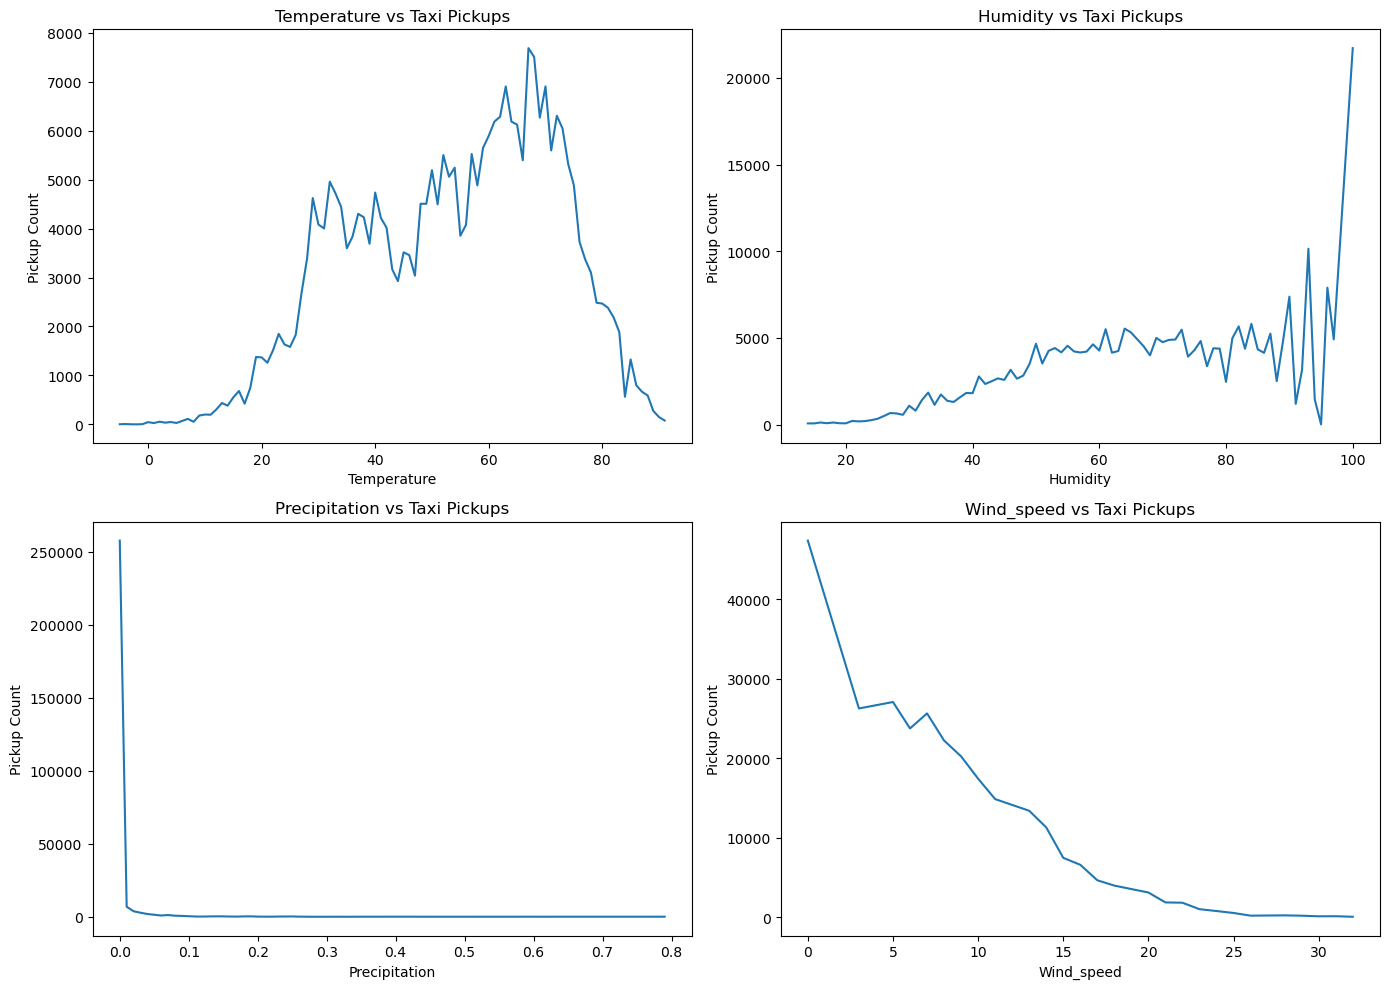

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 개별 데이터의 특징 파악을 위해 샘플 데이터 추출, 판다스 df로 변환
sample_df = joined_df.sample(fraction=0.01, seed=42).toPandas()

# 필요한 날씨 요소 목록
weather_factors = ["temperature", "humidity", "precipitation", "wind_speed"]

# 날씨 요소별 픽업 수 계산
weather_pickup_data = {}
for factor in weather_factors:
    weather_pickup_data[factor] = sample_df.groupby(factor)["pickup_hour"].count().reset_index()
    weather_pickup_data[factor].columns = [factor, "pickup_count"]

# 그래프 설정
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# 그래프 그리기
for i, factor in enumerate(weather_factors):
    sns.lineplot(data=weather_pickup_data[factor], x=factor, y="pickup_count", ax=axes[i])
    axes[i].set_title(f"{factor.capitalize()} vs Taxi Pickups")
    axes[i].set_xlabel(factor.capitalize())
    axes[i].set_ylabel("Pickup Count")

plt.tight_layout()
plt.show()

##### 1. 기온(Temperature) vs 픽업 수

- 30~70°F 구간에서 픽업 수가 많음
- 80°F 이상에서 급격히 감소 → 너무 더운 날에는 이동이 줄어드는 것으로 해석 가능


##### 2. 습도(Humidity) vs 픽업 수

- 습도가 60% 이상부터 픽업 수가 증가
- 90% 이상에서 급증 → 높은 습도가 사람들이 택시를 더 많이 타게 만드는 요인일 가능성 있음


##### 3. 강수량(Precipitation) vs 픽업 수

- 거의 0에 가까운 값이 대부분 → 강수량이 적은 날이 훨씬 많기 때문
- 강수량이 높은 날에 픽업이 적음 → 예상과 반대, 강수량이 많을수록 택시가 덜 잡히거나 수요-공급 불균형 발생 가능성


##### 4. 풍속(Wind Speed) vs 픽업 수

- 바람이 강해질수록 픽업이 감소 → 날씨가 너무 거칠면 외출을 줄이는 영향일 수 있음
- 풍속이 0~5mph에서 가장 많음

### 분석3. 강수가 있는 날과 아닌 날의 픽업 수 차이 분석

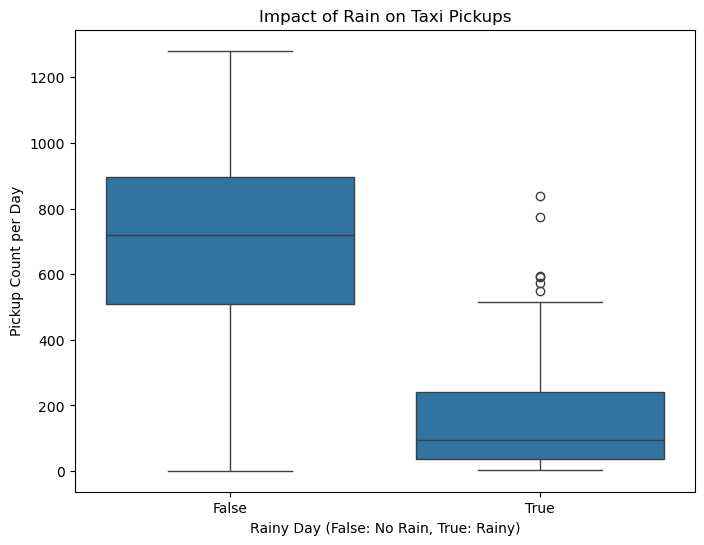

In [113]:
# 강수량이 있는 날(Precipitation > 0)과 없는 날(Precipitation = 0) 구분
sample_df["rainy_day"] = sample_df["precipitation"] > 0

# 강수량 그룹별 평균 픽업 횟수 계산
pickup_counts = sample_df.groupby(["weather_date", "rainy_day"])["pickup_hour"].count().reset_index()

# 그룹화된 데이터프레임 확인
pickup_counts.columns = ["weather_date", "rainy_day", "pickup_count"]

# 박스플롯 시각화
plt.figure(figsize=(8, 6))
sns.boxplot(x="rainy_day", y="pickup_count", data=pickup_counts)
plt.title("Impact of Rain on Taxi Pickups")
plt.xlabel("Rainy Day (False: No Rain, True: Rainy)")
plt.ylabel("Pickup Count per Day")
plt.show()

==> 일반적으로 비가 오면 대중교통보다 택시를 더 많이 이용할 것으로 예상했으나, 비오는 날에 택시 픽업수가 줄었다.

==> NYC에 비가 오면 사람들이 아예 외출을 자제한다라는 예상을 할 수 있음

/var/folders/6m/1m31rdkj22b_lj6j8fgq4r180000gn/T/ipykernel_92122/3668137659.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commute_hours['rainy_day'] = commute_hours['precipitation'] > 0


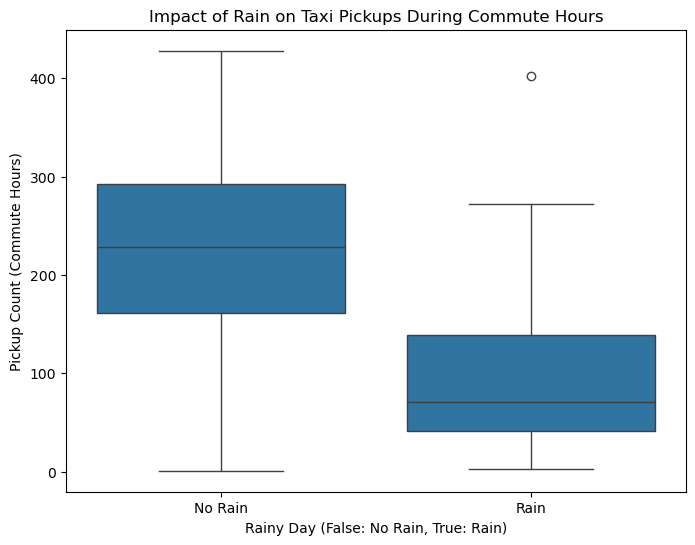

In [114]:
# 그렇다면 모든 시간대 말고, 출퇴근 시간대에만 준 영향을 분석해본다
# 출퇴근 시간대 필터링 (7~9시, 17~19시)
commute_hours = sample_df[(sample_df['pickup_hour'].between(7, 9)) | (sample_df['pickup_hour'].between(17, 19))]

# 비 오는 날 여부 추가
commute_hours['rainy_day'] = commute_hours['precipitation'] > 0

# 일별 픽업 수 집계
pickup_counts = commute_hours.groupby(['pickup_date', 'rainy_day']).size().reset_index(name='pickup_count')

# 박스플롯 시각화
plt.figure(figsize=(8, 6))
sns.boxplot(x="rainy_day", y="pickup_count", data=pickup_counts)
plt.xticks([0, 1], ["No Rain", "Rain"])
plt.xlabel("Rainy Day (False: No Rain, True: Rain)")
plt.ylabel("Pickup Count (Commute Hours)")
plt.title("Impact of Rain on Taxi Pickups During Commute Hours")
plt.show()

==> 출퇴근 시간대에 비가 온다고 해서 택시를 많이 타는 것도 딱히 아니었다

In [116]:
spark.stop()